In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import json
import textwrap
import pandas as pd
from ipywidgets import widgets
from IPython.display import display
from ipywidgets import HBox
import matplotlib.pyplot as plt
from tabulate import tabulate

In [3]:
# Load the wandb table data
def load_wandb_data(filepath):
    with open(filepath, 'r') as f:
        data = json.load(f)
    return pd.DataFrame(data['data'], columns=data['columns'])

In [6]:
def fixedwidth(text):
    """Wrap text to fixed width"""
    return "\n".join(textwrap.wrap(str(text), width=160, replace_whitespace=False))

def format_row(row):
    """Format a single row for display as a table"""
    data = [
        ["Step", row['Step']],
        ["Reward", f"{row['Reward']:.2f}"],
        ["Input", row['Input']],
        ["Prompt", fixedwidth(row['Prompt'])], 
        ["Completion", fixedwidth(row['Completion'])],
    ]
    return tabulate(data, tablefmt='grid')

def present_row(row):
    """Display a formatted row as table"""
    print(format_row(row))

In [7]:
def create_browse_app(df):
    """Create an interactive widget to browse through the data"""
    def browse_data(i=0):
        row = df.iloc[i]
        present_row(row)

    index = widgets.IntText(value=0, description='Index:')
    left_button = widgets.Button(description='Previous')
    right_button = widgets.Button(description='Next')

    def on_left_button_clicked(b):
        if index.value > 0:
            index.value -= 1

    def on_right_button_clicked(b):
        if index.value < len(df) - 1:
            index.value += 1

    left_button.on_click(on_left_button_clicked)
    right_button.on_click(on_right_button_clicked)

    ui = HBox([left_button, index, right_button])
    out = widgets.interactive_output(browse_data, {'i': index})

    display(ui, out)

In [8]:
def preprocess_df(df):
    df['Step'] = df['Step'].astype(int)
    df['Reward'] = df['Reward'].astype(float)
    df['Input'] = df['Input'].astype(str)
    df['Prompt'] = df['Prompt'].astype(str)
    df['Completion'] = df['Completion'].astype(str)
    df['Prompt'] = df['Prompt'].map(lambda x: x.rsplit('**user**:', 1)[-1])
    df.sort_values(by="Step", ascending=False, inplace=True)
    return df

In [9]:
# Load and display your data
from pathlib import Path

# read all json files in the directory using pathlib
run_name = "run-20250427_095435-w2o0v0nl"
directory = f"../wandb/{run_name}/files/media/table"
files = list(Path(directory).glob("interactions_*.json"))

# load all json files
df = pd.concat([load_wandb_data(f) for f in files])
df = preprocess_df(df)
print(len(df))

119808


In [10]:
df.loc[df['Completion'].str.contains("timed out")]

,Step,Input,Prompt,Completion,Reward


In [11]:
# Create the interactive browser
create_browse_app(df)

Output()

In [14]:
retrieval_attempt_mask = df['Completion'].str.contains("timed out")
df.loc[retrieval_attempt_mask]

,Step,Input,Prompt,Completion,Reward
32,982,id: 2hop__20921_20732\n\nanswer: 1978\n\nanswe...,When did the person with the most number one ...,**assistant**: <think> We need to identify the...,3.33
19,680,id: 3hop1__222807_488956_368521\n\nanswer: War...,In which county is the birthplace of the auth...,**assistant**: <think> To find the birthplace ...,1.47


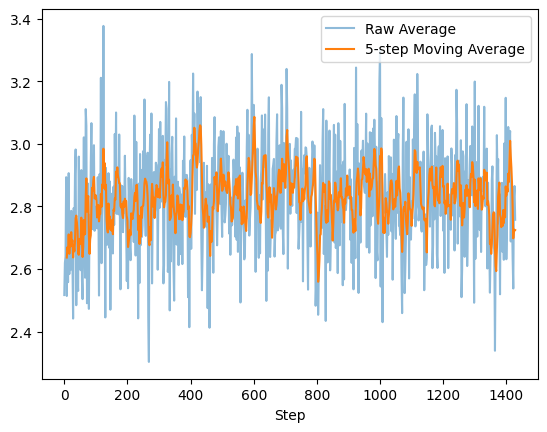

In [15]:
# plot average reward by step
# Plot raw average and moving average
means = df.groupby('Step')['Reward'].mean()
means.plot(alpha=0.5, label='Raw Average')
means.rolling(window=5).mean().plot(label='5-step Moving Average')
plt.legend()

In [16]:
from ast import literal_eval

def extract_titles(completion):
    # Extract titles from the completion
    for line in completion.splitlines():
        if line.startswith('#'):
            yield line.split('#')[1].strip()

# Apply the function to the 'Completion' column
df['Retrieved Titles'] = df['Completion'].apply(lambda x: list(extract_titles(x)))

df['Supporting Titles'] = df['Input'].map(lambda x: x.split('supporting_titles:', 1)[-1]).map(literal_eval)


In [18]:
df['Retrieved Titles'].map(len).describe()

count    205920.000000
mean          2.245207
std           0.675295
min           0.000000
25%           2.000000
50%           2.000000
75%           3.000000
max          32.000000
Name: Retrieved Titles, dtype: float64

<Axes: >

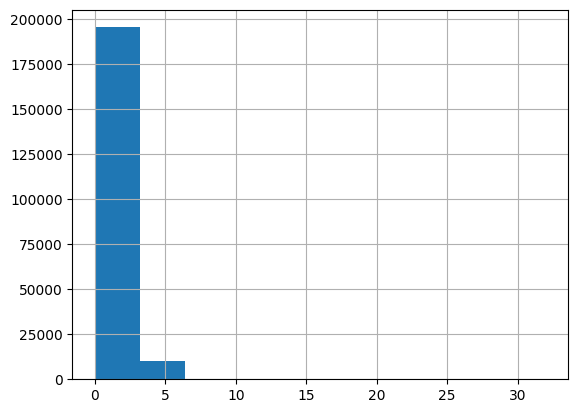

In [17]:
df['Retrieved Titles'].map(len).hist()

In [19]:
df['Successfully Retrieved Titles'] = df.apply(lambda row: set(row['Retrieved Titles']).intersection(row['Supporting Titles']), axis=1)
df['retrieval.recall'] = df['Successfully Retrieved Titles'].map(len) / df['Supporting Titles'].map(len)
df['retrieval.precision'] = df['Successfully Retrieved Titles'].map(len) / df['Retrieved Titles'].map(len)

In [20]:
retrieval_attempt_mask = df['Retrieved Titles'].map(len) > 0
len(df[retrieval_attempt_mask]) / len(df)

0.9962606837606838

In [21]:
df.loc[retrieval_attempt_mask, 'retrieval.recall'].describe()

count    205150.000000
mean          0.820360
std           0.258804
min           0.000000
25%           0.666667
50%           1.000000
75%           1.000000
max           1.000000
Name: retrieval.recall, dtype: float64

In [22]:
df.loc[retrieval_attempt_mask, 'retrieval.precision'].describe()

count    205150.000000
mean          0.858177
std           0.251242
min           0.000000
25%           0.666667
50%           1.000000
75%           1.000000
max           1.000000
Name: retrieval.precision, dtype: float64

In [23]:
error_mask = df['Completion'].str.contains("Error")
len(df.loc[error_mask]) / len(df)


0.055123348873348875

<Axes: >

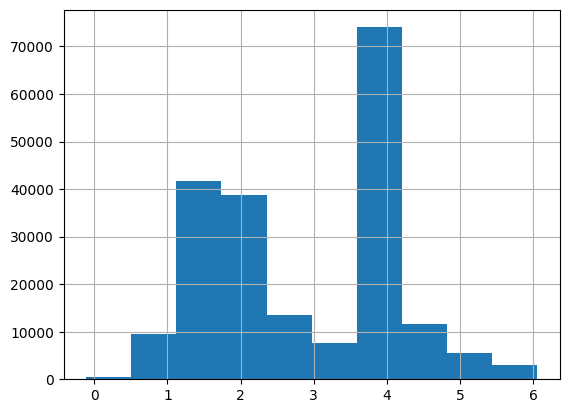

In [24]:
df['Reward'].hist()

In [25]:
# plot reward distribution characteristics per prompt
prompt_reward_stats = df.groupby('Prompt')['Reward'].describe()

<Axes: xlabel='std', ylabel='mean'>

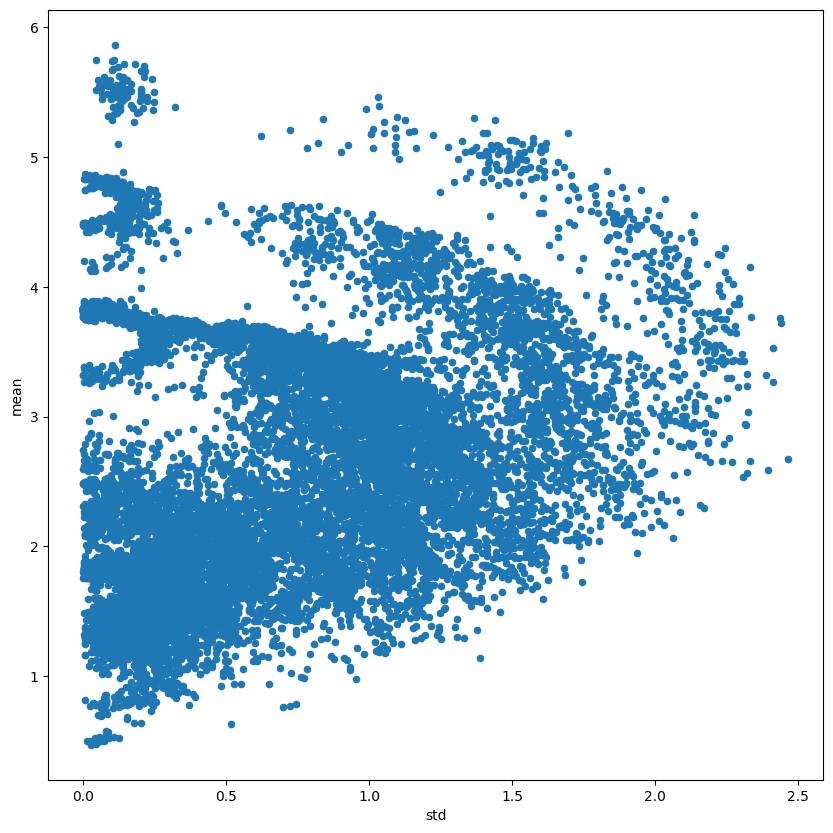

In [26]:
prompt_reward_stats.plot.scatter(x='std', y='mean', figsize=(10, 10))

In [28]:
df['n_hops'] = df['Supporting Titles'].map(len)

In [38]:
df['Step'].describe()

count    205920.000000
mean        714.000000
std         412.806041
min           0.000000
25%         356.000000
50%         714.000000
75%        1072.000000
max        1428.000000
Name: Step, dtype: float64

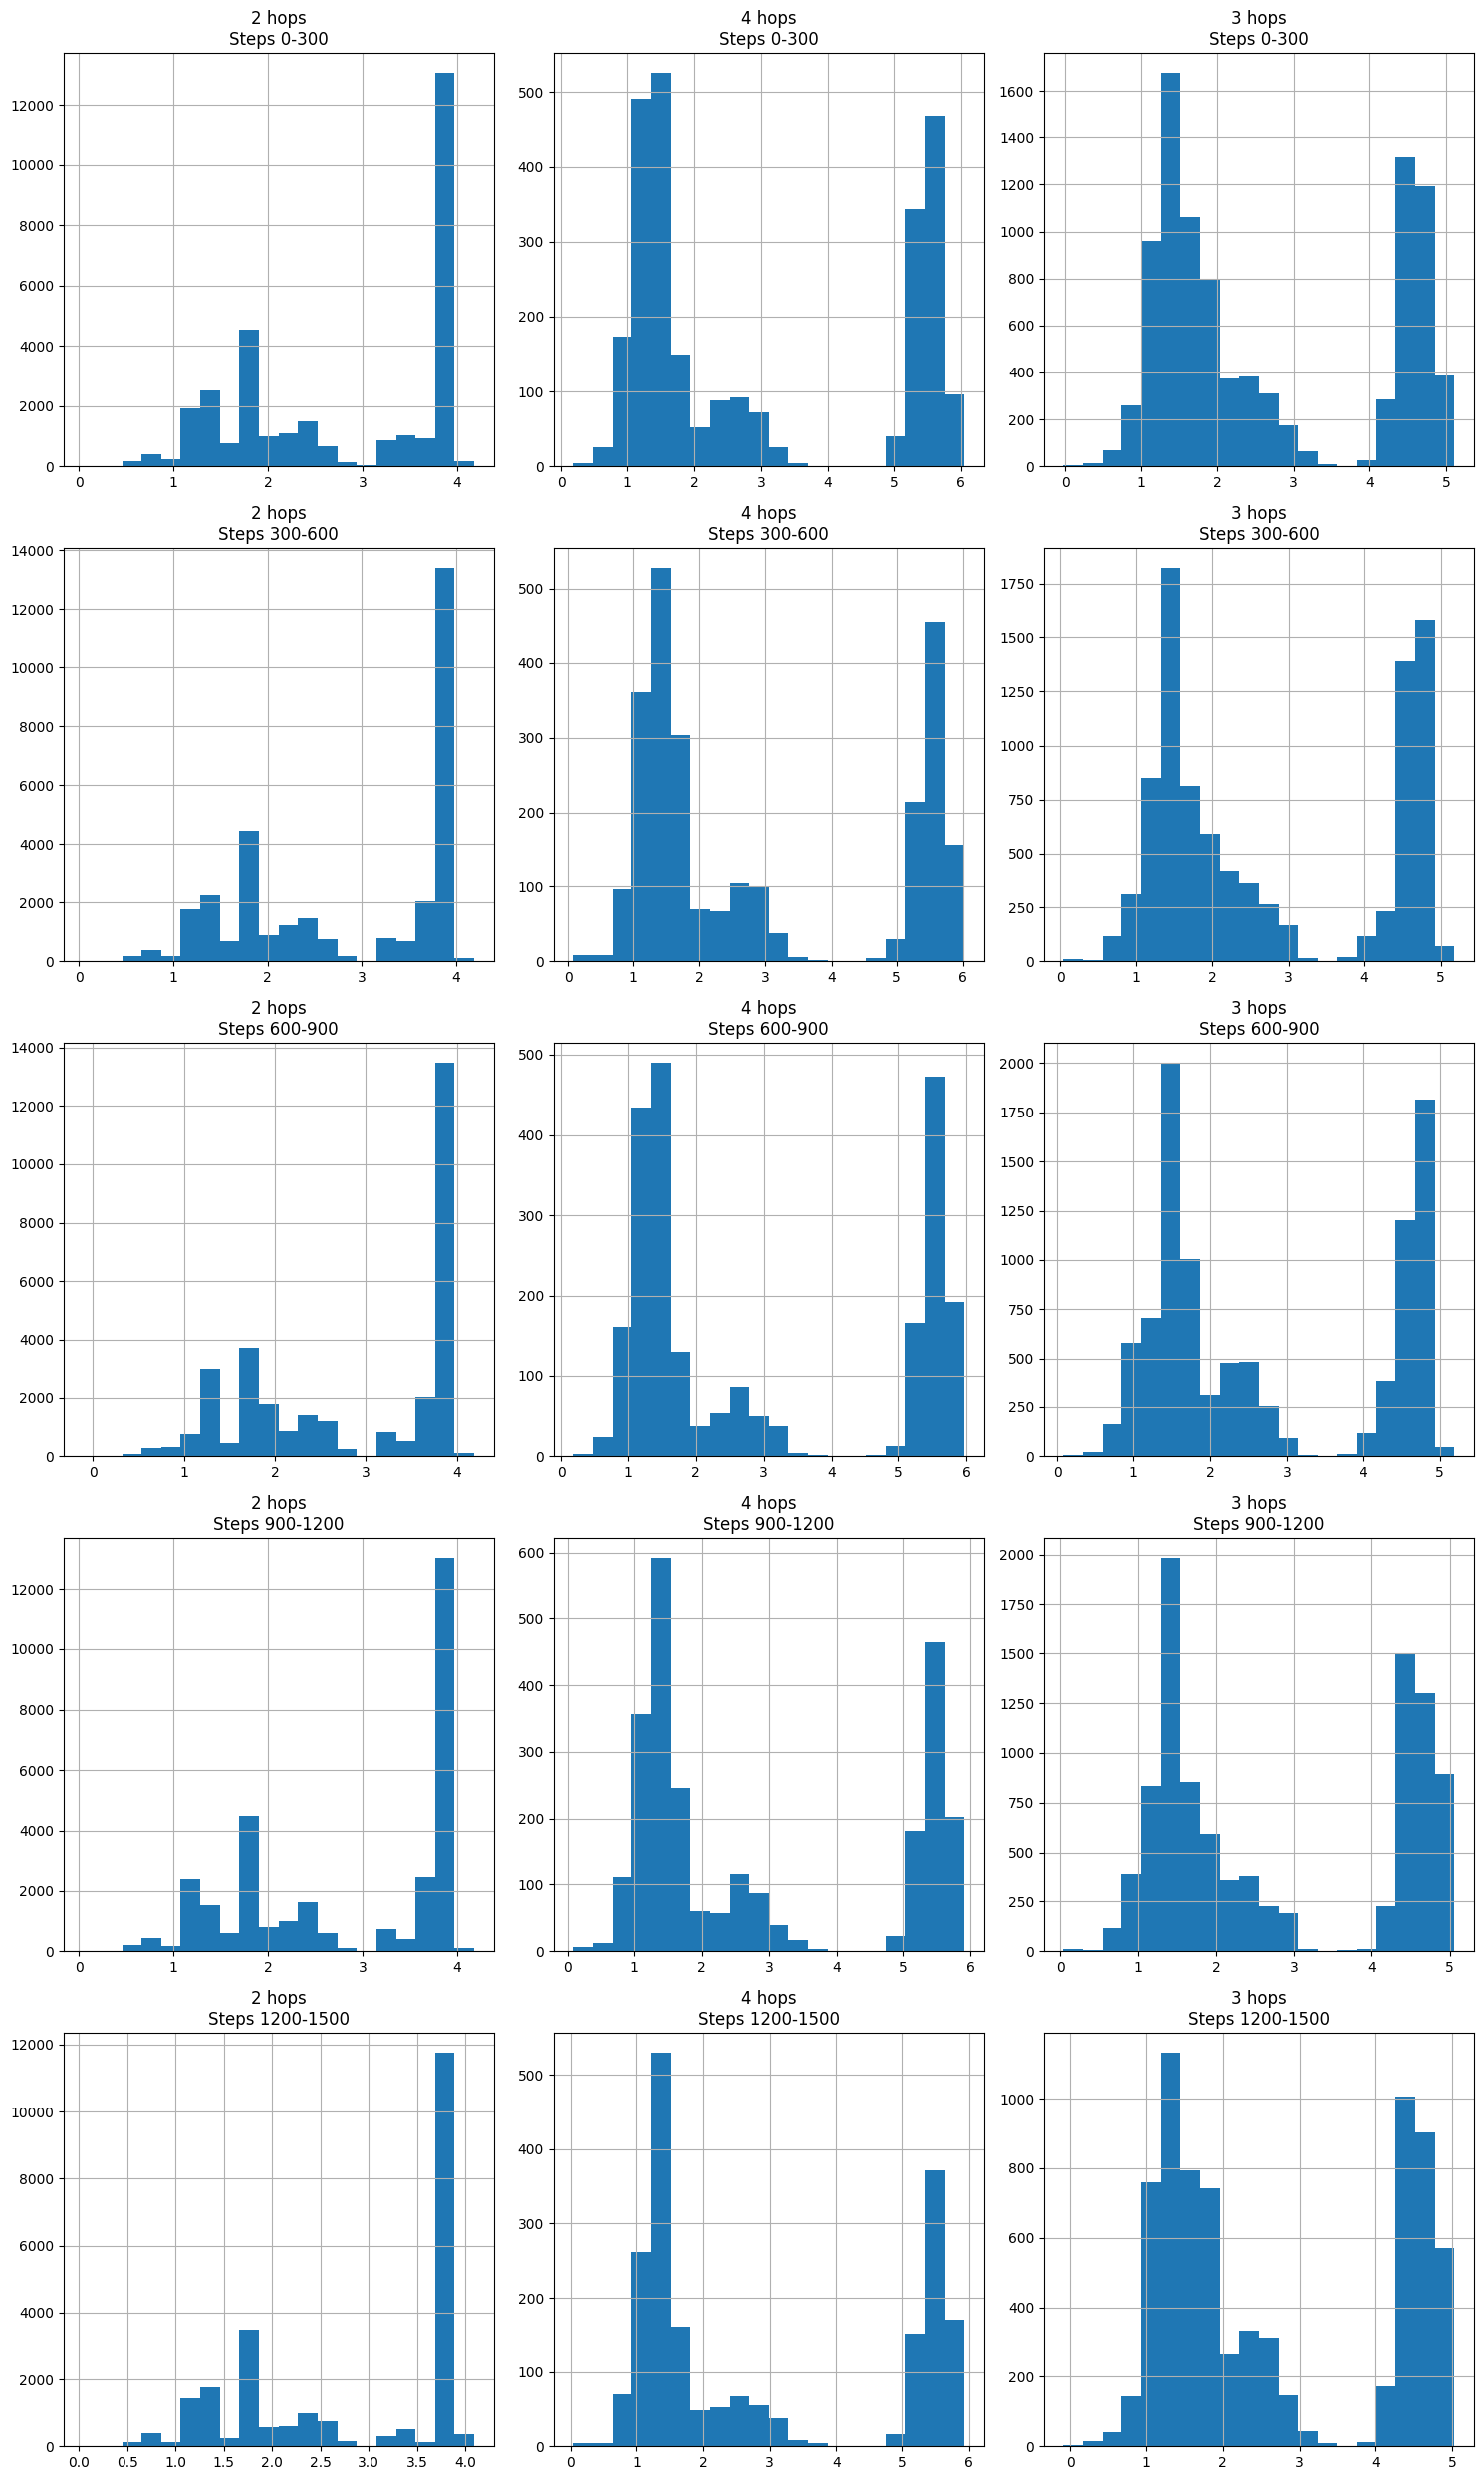

In [39]:
# plot reward distribution characteristics per n_hops for different step ranges
interval = 300
step_ranges = [(i, i+interval) for i in range(0, int(df['Step'].max()), interval)]
n_hops_values = df['n_hops'].unique()

fig, axes = plt.subplots(len(step_ranges), 3, figsize=(15, 5*len(step_ranges)))
axes = axes.reshape(len(step_ranges), 3)

for row, (step_start, step_end) in enumerate(step_ranges):
    df_step = df[(df['Step'] >= step_start) & (df['Step'] < step_end)]
    
    for col, n_hops in enumerate(n_hops_values):
        df_step_n_hops = df_step[df_step['n_hops'] == n_hops]
        df_step_n_hops['Reward'].hist(bins=20, ax=axes[row,col])
        axes[row,col].set_title(f'{n_hops} hops\nSteps {step_start}-{step_end}')

plt.tight_layout()
